# Observing cell movement:

In [1]:
import cv2
import os

# Path to folder containing numbered photos
folder_path = 'Data/Exp_grp/'

# Get sorted list of photo filenames
photo_filenames = sorted([os.path.join(folder_path, filename) for filename in os.listdir(folder_path) if filename.endswith('.jpg')])

# Initialize counter for frame number
frame_num = 0

while True:
    # Read next photo
    if frame_num < len(photo_filenames):
        frame = cv2.imread(photo_filenames[frame_num])
    else:
        break

    # Convert photo to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Apply a threshold to segment the cells
    _, thresh = cv2.threshold(gray, 140, 180, cv2.THRESH_BINARY)

    # Find contours of cells
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw contours on original photo
    cv2.drawContours(frame, contours, -1, (0, 255, 0), 3)

    # Show photo with cell contours
    cv2.imshow('Cell Movement', frame)

    # Increment frame number
    frame_num += 1

    # Press 'q' to exit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Close window
cv2.destroyAllWindows()


# Cell Tracking

In [2]:
import cv2
import numpy as np
import pandas as pd
import os

# Path to folder containing numbered photos
folder_path = 'Data/Exp_grp/'

# Get sorted list of photo filenames
photo_filenames = sorted([filename for filename in os.listdir(folder_path) if filename.endswith('.jpg')])

# Initialize DataFrame to store tracking information
df = pd.DataFrame(columns=['frame', 'cell_id', 'x', 'y'])

# Initialize dictionary to store cell positions
cell_positions = {}

# Initialize cell ID counter
cell_id_counter = 0

# Loop over all photos
for i, photo_filename in enumerate(photo_filenames):
    # Read photo
    photo = cv2.imread(os.path.join(folder_path, photo_filename))

    # Convert photo to grayscale
    gray = cv2.cvtColor(photo, cv2.COLOR_BGR2GRAY)

    # Apply a threshold to segment the cells
    _, thresh = cv2.threshold(gray,130 , 200, cv2.THRESH_BINARY)
# Find all contours and reconstruct the full hierarchy
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Create a dictionary to store the cell contours by their ID
cell_contours = {}

# Loop over all cells
for i, contour in enumerate(contours):
    # Calculate moments of cell contour
    M = cv2.moments(contour)

    # Skip contour with moment of zero
    if M['m00'] == 0:
        continue

    # Calculate centroid of cell
    cx = int(M['m10'] / M['m00'])
    cy = int(M['m01'] / M['m00'])

    # Find parent cell contour
    parent_id = None
    for j, parent_contour in cell_contours.items():
        if j == i:
            continue
        if cv2.pointPolygonTest(parent_contour, (cx, cy), False) == 1:
            parent_id = j
            break

    # If no parent cell found, assign new cell ID
    if parent_id is None:
        cell_id = cell_id_counter
        cell_id_counter += 1
    # If parent cell found, use its ID
    else:
        cell_id = cell_ids[parent_id]

    # Add cell ID to list
    cell_ids[i] = cell_id

    # Add cell contour to dictionary
    if parent_id is None:
        cell_contours[cell_id] = {i: contour}
    else:
        if parent_id in cell_contours:
            parent_contour = cell_contours[parent_id]
            parent_contour.update({i: contour})
            cell_contours[parent_id] = parent_contour
        else:
            cell_contours[parent_id] = {i: contour}

# Update cell positions dictionary
cell_positions_new = {}
for j, contour in cell_contours.items():
    # Calculate moments of cell contour
    M = cv2.moments(contour)

    # Skip contour with moment of zero
    if M['m00'] == 0:
        continue

    # Calculate centroid of cell
    cx = int(M['m10'] / M['m00'])
    cy = int(M['m01'] / M['m00'])

    # If cell is new, assign new cell ID and add to DataFrame
    if j not in cell_positions:
        cell_positions_new[j] = (cell_id_counter, cx, cy)
        df = df.append({'frame': i, 'cell_id': cell_id_counter, 'x': cx, 'y': cy}, ignore_index=True)
        cell_id_counter += 1
    # If cell is already tracked, update its position
    else:
        cell_id, _, _ = cell_positions[j]
        cell_positions_new[j] = (cell_id, cx, cy)
        df = df.append({'frame': i, 'cell_id': cell_id, 'x': cx, 'y': cy}, ignore_index=True)

# Remove cells that were not detected in the current frame
for j in cell_positions:
    if j not in cell_positions_new:
        cell_id, _, _ = cell_positions[j]
        df = df.append({'frame': i, 'cell_id': cell_id, 'x': np.nan, 'y': np.nan}, ignore_index=True)

# Update cell positions dictionary
cell_positions = cell_positions_new.copy()




# Write DataFrame to CSV file
df.to_csv('cell_tracking.csv', index=False)


NameError: name 'cell_ids' is not defined

In [6]:
import os
import cv2
import pandas as pd
import numpy as np


def preprocess_image(frame):
    # Convert to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # Apply Gaussian blur to reduce noise
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    # Apply adaptive thresholding to create binary image
    thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)
    return thresh


def track_cells_in_frame(frame_number, contours, cell_positions, cell_id_counter):
    # Dictionary to store new cell positions in this frame
    cell_positions_new = {}
    # Loop over each contour in this frame
    for contour in contours:
        # Calculate centroid of contour
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
            # Find closest cell in previous frame
            closest_cell_id = find_closest_cell_id((cx, cy), cell_positions)
            # Add new position to dictionary
            cell_positions_new[cell_id_counter] = {'frame': frame_number, 'cell_id': cell_id_counter, 'x': cx, 'y': cy,
                                                    'parent_id': closest_cell_id}
            # Increment cell ID counter
            cell_id_counter += 1
    return cell_positions_new, cell_id_counter


def find_closest_cell_id(point, cell_positions):
    # Calculate distance from point to each cell position in previous frame
    distances = {}
    for cell_id, cell_position in cell_positions.items():
        distances[cell_id] = np.sqrt((point[0] - cell_position['x']) ** 2 + (point[1] - cell_position['y']) ** 2)
    # Find cell with minimum distance
    if distances:
        return min(distances, key=distances.get)
    else:
        return None


def update_dataframe(df, frame_number, cell_positions, cell_positions_new):
    # Remove rows for cells that were not detected in this frame
    df = df[df['frame'] != frame_number]
    # Create new DataFrame with updated cell positions
    df_new = pd.DataFrame(cell_positions_new.values())
    # Merge with original DataFrame
    df = pd.concat([df, df_new])
    # Update parent IDs for child cells
    for index, row in df.iterrows():
        if not pd.isna(row['parent_id']):
            parent_id = int(row['parent_id'])
            df.at[index, 'parent_id'] = cell_positions[parent_id]['cell_id']
    return df
def track_cells(photo_filenames, folder_path):
    # Initialize DataFrame to store tracking information
    df = pd.DataFrame(columns=['frame', 'cell_id', 'x', 'y'])

    # Initialize dictionary to store cell positions
    cell_positions = {}

    # Initialize cell ID counter
    cell_id_counter = 0

    # Loop over all photos
    for i, photo_filename in enumerate(photo_filenames):
        # Read photo
        photo = cv2.imread(os.path.join(folder_path, photo_filename))

        # Convert photo to grayscale
        gray = cv2.cvtColor(photo, cv2.COLOR_BGR2GRAY)

        # Apply a threshold to segment the cells
        _, thresh = cv2.threshold(gray, 180, 255, cv2.THRESH_BINARY)

        # Find contours of cells
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Track cells in this frame
        cell_positions_new, cell_id_counter = track_cells_in_frame(i, contours, cell_positions, cell_id_counter)

        # Update DataFrame with tracked cell positions
        update_dataframe(df, i, cell_positions, cell_positions_new)

        # Update cell_positions dictionary
        cell_positions = cell_positions_new.copy()

    # Write DataFrame to CSV file
    df.to_csv('cell_tracking.csv', index=False)


In [7]:
folder_path = 'Data/Exp_grp/'
photo_filenames = sorted([filename for filename in os.listdir(folder_path) if filename.endswith('.jpg')])

df = track_cells(photo_filenames, folder_path)


In [ ]:
import cv2
import pandas as pd
import os

# Set path to image folder
image_folder = 'Data/Exp_grp/'

# Initialize DataFrame to store cell tracking data
cell_tracking = pd.DataFrame(columns=['frame', 'cell_id', 'cx', 'cy'])

# Loop over all image files in folder
for i, filename in enumerate(sorted(os.listdir(image_folder))):
    if not filename.endswith('.jpg'):
        continue
    
    # Load image
    img = cv2.imread(os.path.join(image_folder, filename))
    
    # Convert image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Apply a threshold to segment the cells
    _, thresh = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY)
    
    # Find contours of cells
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Loop over each cell contour
    for j, contour in enumerate(contours):
        # Calculate moment of contour
        M = cv2.moments(contour)
        
        # Skip contour with moment of zero
        if M['m00'] == 0:
            continue
        
        # Calculate centroid of cell
        cx = int(M['m10'] / M['m00'])
        cy = int(M['m01'] / M['m00'])
        
        # If cell is new, assign new cell ID and add to DataFrame
        if (cell_tracking['frame'] == i).sum() == 0:
            cell_id = j
            cell_tracking = cell_tracking.append({'frame': i, 'cell_id': cell_id, 'cx': cx, 'cy': cy}, ignore_index=True)
        # If cell already exists, update its position in the DataFrame
        else:
            cell_id = cell_tracking.loc[(cell_tracking['frame'] == i) & (cell_tracking['cx'] == cx) & (cell_tracking['cy'] == cy), 'cell_id'].values[0]
            cell_tracking.loc[(cell_tracking['frame'] == i) & (cell_tracking['cell_id'] == cell_id), 'cx'] = cx
            cell_tracking.loc[(cell_tracking['frame'] == i) & (cell_tracking['cell_id'] == cell_id), 'cy'] = cy
            
# Save DataFrame as CSV file
cell_tracking.to_csv('cell_tracking.csv', index=False)


# Analyzing cell movement:

C:\Users\Ajit\AppData\Local\Temp\ipykernel_13088\1739340627.py:12: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  tracking_data['MSD'] = tracking_data.groupby('cell_id')['displacement'].apply(lambda x: x.pow(2).rolling(window=10, min_periods=1).mean())
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


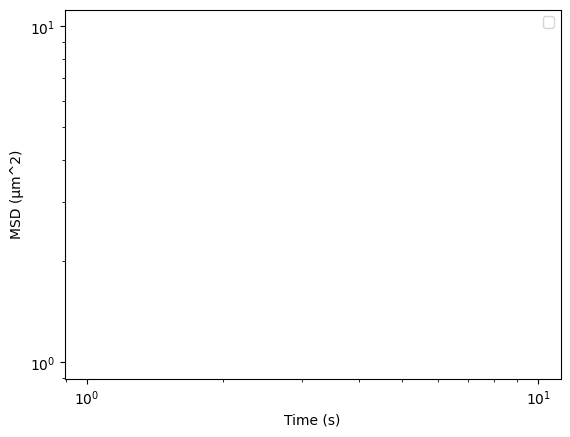

In [1]:
import pandas as pd
import numpy as np

# Load cell tracking data
tracking_data = pd.read_csv('cell_tracking.csv')

# Calculate mean square displacement (MSD) for each cell
tracking_data['dx'] = tracking_data['x'] - tracking_data['x'].shift()
tracking_data['dy'] = tracking_data['y'] - tracking_data['y'].shift()
tracking_data['displacement'] = np.sqrt(tracking_data['dx']**2 + tracking_data['dy']**2)
tracking_data['time'] = tracking_data['frame'] * 0.1 # Assuming 10 frames per second
tracking_data['MSD'] = tracking_data.groupby('cell_id')['displacement'].apply(lambda x: x.pow(2).rolling(window=10, min_periods=1).mean())

# Plot MSD versus time
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
for cell_id, cell_data in tracking_data.groupby('cell_id'):
    ax.plot(cell_data['time'], cell_data['MSD'], label=f'Cell {cell_id}')
ax.set_xlabel('Time (s)')
ax.set_ylabel('MSD (μm^2)')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
plt.show()


# Testing for chemotaxis:

In [ ]:
# Load cell tracking and chemotaxis data
tracking_data = pd.read_csv('cell_tracking.csv')
chemotaxis_data = pd.read_csv('chemotaxis_data.csv')

# Calculate chemotactic index (CI) for each cell
CI_data = pd.DataFrame()
for cell_id, cell_data in tracking_data.groupby('cell_id'):
    # Get cell trajectory
    x = cell_data['x'].values
    y = cell_data['y'].values
    time = cell_data['frame'].values * 0.1 # Assuming 10 frames per second
    
    # Interpolate chemotaxis data onto cell trajectory
    chemo_interp = np.interp(time, chemotaxis_data['time'].values, chemotaxis_data['chemoattractant_concentration'].values)
    
    # Calculate directionality of cell movement
    dx = np.gradient(x)
    dy = np.gradient(y)
    angle = np.arctan2(dy, dx)
    
    # Calculate chemotactic index
    cos_angle = np.cos(angle)
    CI = np.sum(cos_angle * chemo_interp) / np.sum(chemo_interp)
    
    # Add CI to dataframe
    CI_data = CI_data.append({'cell_id': cell_id, 'chemotactic_index': CI}, ignore_index=True)

# Plot histogram of chemotactic indices
fig, ax = plt.subplots()
ax.hist(CI_data['chemotactic_index'], bins=20)
ax.set_xlabel('Chemotactic Index')
ax.set_ylabel('Number of Cells')
plt.show()
